# Treinamento regressão

In [1]:
treinar = {
    'GP': False,
    'RegressaoLinear': False,
    'BayesianPolinomialLinearRegression': False,
    'BayesianLinearRegression': False,
    'RBFLinearRegression': True,
}

## Conjunto de dados

In [2]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('housesToRentProcessed.csv')

X = dataset[[
    'São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte', 
    'area',
    'rooms', 'bathroom', 'parking spaces', 'floor', 'isHouse', 'animal', 'furniture',
]].values
y = dataset[['y con + alu']].values

### Descrição do conjunto de dados

| Atributo         | Descrição                                           | Valor  |
| ---------------- | --------------------------------------------------- | ------ |
| `São Paulo`      | Imóvel está localizado na cidade de São Paulo?      | `int: 0 false - 1 true` |
| `Porto Alegre`   | Imóvel está localizado na cidade de Porto Alegre?   | `int: 0 false - 1 true` |
| `Rio de Janeiro` | Imóvel está localizado na cidade de Rio de Janeiro? | `int: 0 false - 1 true` |
| `Campinas`       | Imóvel está localizado na cidade de Campinas?       | `int: 0 false - 1 true` |
| `Belo Horizonte` | Imóvel está localizado na cidade de Belo Horizonte? | `int: 0 false - 1 true` |
| `area`           | Área do imóvel (em metros quadrados)                | `float` |
| `rooms`          | Quantidade de quartos                               | `int` |
| `bathroom`       | Quantidade de banheiros                             | `int` |
| `floor`          | Andar localizado o imóvel                           | `int`. `0` pressuposto para casa |
| `isHouse`        | Imóvel corresponde a um aluguel de casa             | `int: 0 false - 1 true` |
| `animal`         | É possivel levar animais para o imóvel              | `int: 0 false - 1 true` |
| `furniture`      | ?                      | `int: 0 false - 1 true` |
| `y con + alu`    | Valor mensal total do aluguel do imóvel: aluguel + taxa de condomínio. | `float` |

In [3]:
dataset.head()

,São Paulo,Porto Alegre,Rio de Janeiro,Campinas,Belo Horizonte,area,rooms,bathroom,parking spaces,floor,isHouse,animal,furniture,y con + alu
0,1,0,0,0,0,70,2,1,1,7,0,1,1,5365
1,1,0,0,0,0,320,4,4,0,20,0,1,0,6160
2,0,1,0,0,0,80,1,1,1,6,0,1,0,3800
3,0,1,0,0,0,51,2,1,0,2,0,1,0,1382
4,1,0,0,0,0,25,1,1,0,1,0,0,0,800


### Separação de treino e teste

Os dados foram separados em treino e em teste seguindo a proporção de $70\%$ para treino e de $30\%$ para testes. O processo de seleção do modelo será descrito posteriormente.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train[:10]
y_train = y_train[:10]

print('Quantidade de elementos para o treinamento:', X_train.shape)
print('Quantidade de elementos selecionados para teste:', X_test.shape)

Quantidade de elementos para o treinamento: (10, 13)
Quantidade de elementos selecionados para teste: (3208, 13)


### Normalização

A normalização aplicada no conjunto de dados foi a [min/max scalling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler):
\begin{aligned}
\mathcal{D}_{std} &= \frac{\mathcal{D} - \mathcal{D}.min(axis=0)}{\mathcal{D}.max(axis=0) - \mathcal{D}.min(axis=0)}; \\
\mathcal{D}_{scaled} &= \mathcal{D}_{std} \cdot (max - min) + min.
\end{aligned}
A transformação aplicada, escala (dimensiona) e translada cada característica individualmente, de modo que esta esteja entre o intervalo $[0, 1]$.

Como poderá ser visto adiante, este trabalho tomou o cuidado dos dados de validação e de teste serem transformados conforme os dados  a escala definida no treinamento.

In [5]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler

## Treinamento

Com o intuito de selecionar os melhores hiperparâmetros, para cada um dos modelo testados, foi realizado uma validação cruzada por meio de _5-folds_, onde ocorreu uma otimização bayesiana em cada um dos _folds_. Os hiperparâmetros foram selecionados de acordo com o resultado da métrica **DECIDIR**, descrita adiante neste trabalho.

Após a seleção dos hiperparâmetros, cada um dos modelos foram avaliados com conjunto de testes por meio das métricas descritas a seguir.

### Métricas

#### Root Mean Squared Error (RMSE)

__Root Mean Squared Error__ ou raiz do erro quadrático médio [_terminar_]

\begin{aligned}
\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \frac{1}{N_\text{teste}} \sum_{i=1}^{N_\text{teste}} (y_i - \hat{y}_i)^2; \\
\text{RMSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \sqrt{\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}})}
\end{aligned}

In [6]:
from trabalho.util.metrica import rmse

#### Negative Log Predictive Density (NLPD)

A métrica **Negative Log Predictive Density** (NLPD) leva em consideração a variância predita $\hat{\sigma}_i^2$, além dos valores esperados e preditos (média):

\begin{aligned}
\text{NLPD}
&= -\frac{1}{N_\text{teste}}
    \sum_{i=1}^{N_\text{teste}}
    \log 
    \overbrace{p(y_i|\boldsymbol{x}_i, \boldsymbol{y}, \boldsymbol{X}, \hat{\boldsymbol{\theta}})}^{\mathcal{N}(y_i|\hat{\mu}_i, \hat{\sigma}_i^2)}
    \\
&= \frac{1}{2}\log2\pi + \frac{1}{2 N_\text{teste}}
\sum_{i=1}^{N_\text{teste}} \left[\log \hat{\sigma}^2_i + \frac{(y_i - \hat{\mu}_i)^2}{\hat{\sigma}^2_i}\right]
\end{aligned}

Conforme já discutido em aula, a NLPD busca realçar modelos equilibrandos, penalizando:
* modelos muito confiantes nos casos de erros grandes ($\sigma^2_i$ baixos para erros maiores), e;
* modelos pouco confiantes nos casos de erros pequenos ($\sigma^2_i$ altos para erros menores).

In [7]:
from trabalho.util.metrica import nlpd

## Modelos utilizados

In [8]:
relatorio_modelos = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold'])

### Processos Gaussianos

In [9]:
from trabalho.modelos.gp import GP

GP

trabalho.modelos.gp.GP

#### Hiperparâmetros a serem procurados

In [10]:
from trabalho.util.otimizacao_bayesiana import Dominio
import gpflow


kernels = [
    # Combinação de kernels
    #gpflow.kernels.Combination(),
    #gpflow.kernels.ChangePoints(),
    #gpflow.kernels.Product(),
    #gpflow.kernels.Sum(),
    
    # Imagem (convolução)
    #gpflow.kernels.Convolutional(),
    
    # Dados estacionários
    #gpflow.kernels.Stationary(),
    #gpflow.kernels.Periodic(), # Can be used to wrap any Stationary kernel to transform it into a periodic version
    #gpflow.kernels.AnisotropicStationary(), 
    #gpflow.kernels.IsotropicStationary(),
    
    # Multi objetivo
    #gpflow.kernels.MultioutputKernel(),
    #gpflow.kernels.IndependentLatent(),
    #gpflow.kernels.LinearCoregionalization(),
    #gpflow.kernels.SeparateIndependent(),
    #gpflow.kernels.SharedIndependent(),
    
    # Outros exóticos
    #gpflow.kernels.Coregion(),
    
    # Ok
    #gpflow.kernels.Kernel(), # Classe base
    #gpflow.kernels.Static(), # Classe base
    
    #gpflow.kernels.ArcCosine(),
    #gpflow.kernels.Constant(),
    #gpflow.kernels.Cosine(),
    #gpflow.kernels.Exponential(),
    #gpflow.kernels.Linear(),
    
    gpflow.kernels.Matern12(),
    gpflow.kernels.Matern32(),
    gpflow.kernels.Matern52(),
    
    #gpflow.kernels.Polynomial(),
    gpflow.kernels.SquaredExponential(), # RBF
    #gpflow.kernels.RationalQuadratic(),
    
    #gpflow.kernels.White(),
]


means = [
    # Padrão
    gpflow.mean_functions.Zero(),
    # Média
    gpflow.mean_functions.Linear(),
]

dominio_gp = Dominio([
    # https://gpflow.readthedocs.io/en/master/gpflow/kernels/#gpflow-kernels-linear
    {
        'name': 'kernel',
        'type': 'categorical',
        'domain': kernels
    },
    {
        'name': 'mean_function',
        'type': 'categorical',
        'domain': means
    },
#     {'name': 'learning_rate',   'type': 'continuous', 'domain': (0.0001, 0.02)},
#     {'name': 'sampling_method', 'type': 'discrete',   'domain': (1, 3, 5)},
#     {'name': 'regularization',  'type': 'continuous', 'domain': (0.00001, 0.01)},
#     {'name': 'batch_size',      'type': 'discrete',   'domain': (10, 16, 32)},
])

dominio_gp.dominio

[{'name': 'kernel', 'type': 'categorical', 'domain': [0, 1, 2, 3]},
 {'name': 'mean_function', 'type': 'categorical', 'domain': [0, 1]}]

### Regressão Linear

#### Regressão Linear (não bayesiana)

In [11]:
from trabalho.modelos.regressao_linear import RegressaoLinear

RegressaoLinear

trabalho.modelos.regressao_linear.RegressaoLinear

##### Hiperparâmetros a serem procurados

In [12]:
dominio_regressao_linear = Dominio([])

#### Regressão Linear Bayesiana

In [13]:
from trabalho.modelos.bayesian_linear_regression import BayesianLinearRegression

BayesianLinearRegression

trabalho.modelos.bayesian_linear_regression.BayesianLinearRegression

##### Hiperparâmetros a serem procurados

In [14]:
dominio_regressao_linear_bayesiana = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    }
])

#### Regressão Linear Bayesiana Polinomial

In [15]:
from trabalho.modelos.bayesian_polinomial_linear_regression import BayesianPolinomialLinearRegression

BayesianPolinomialLinearRegression

trabalho.modelos.bayesian_polinomial_linear_regression.BayesianPolinomialLinearRegression

##### Hiperparâmetros a serem procurados

In [16]:
dominio_regressao_linear_bayesiana_polinomial = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'order',
        'type': 'discrete',
        'domain': (2, 3, 4, 5, 6, 7, 8, 9, 10)
    }
])

#### Regressão Linear Bayesiana com kernel RBF

In [24]:
from trabalho.modelos.rbf_linear_regression import RBFLinearRegression

RBFLinearRegression

ModuleNotFoundError: No module named 'trabalho.util.phi'

##### Hiperparâmetros a serem procurados

In [18]:
dominio_regressao_linear_bayesiana_rbf = Dominio([])

### Validação - Seleção de modelos

In [19]:
from trabalho.util.kfold import KFoldCrossValidation
from GPyOpt.methods import BayesianOptimization
from tqdm import tqdm

def f(Modelo, X, y, X_validation, y_validation, fold, relatorio, **kwargs):
    modelo = Modelo(**kwargs)
    modelo.fit(X, y)
    
    means, vars = modelo.predict(X_validation)
    
    erro_rmse = rmse(means, y_validation)
    erro_nlpd = nlpd(means, vars, y_validation)

    relatorio.loc[len(relatorio)] = [Modelo.__name__, kwargs, erro_rmse, erro_nlpd, fold]

    return erro_rmse


def validacao_cruzada(Modelo, dominio, X, y, max_iter=25, k_folds=5):
    relatorio = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold'])
    
    for i, X_train, X_test, y_train, y_test in tqdm(KFoldCrossValidation(X, y, k_folds).split(), total=k_folds, desc="k-fold"):
        X_scaler = Scaler()
        y_scaler = Scaler()
        
        X            = X_scaler.fit_transform(X_train)
        X_validation = X_scaler.transform(X_test)
        y            = y_scaler.fit_transform(y_train)
        y_validation = y_scaler.transform(y_test)

        funcao = dominio.gerar_f(Modelo=Modelo, f=f, X=X, y=y, X_validation=X_validation, y_validation=y_validation, fold=i, relatorio=relatorio)
        
        bo = BayesianOptimization(f=funcao, domain=dominio.dominio, verbosity=True)
        bo.run_optimization(max_iter=25)

#         print('RMSE:', bo.fx_opt, '(normalizado)')
#         print('RMSE:', y_scaler.inverse_transform([[bo.fx_opt]])[0, 0], '("real")')
#         print('Parâmetros:', bo.x_opt)
        try:
            bo.plot_convergence()
            bo.plot_acquisition()
        except Exception as e:
            print(e)

    return relatorio

In [20]:
if treinar['GP']:
    resultado_parcial = validacao_cruzada(Modelo=GP, dominio=dominio_gp, X=X_train, y=y_train)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])

In [21]:
if treinar['RegressaoLinear']:
    resultado_parcial = validacao_cruzada(Modelo=RegressaoLinear, dominio=dominio_regressao_linear, X=X_train, y=y_train)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])

In [22]:
if treinar['BayesianLinearRegression']:
    resultado_parcial = validacao_cruzada(Modelo=BayesianLinearRegression, dominio=dominio_regressao_linear_bayesiana, X=X_train, y=y_train)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

0.051872343098760265 0.04677311231367947
0.7562206668051777 0.6738533906252975
0.5031101568926145 1.0155397755284503
0.04368256501799735 0.9352781855473508
0.3210194826664162 0.28986254251853033
0.0001 1.1
0.0001 0.0001
0.0001 1.1
1.1 0.0001
1.1 0.0001
1.1 1.1
0.0001 0.0001
0.5638234224695515 0.5129710102039631
1.1 0.0001
0.0001 0.5511533218369814
0.0001 1.1
1.1 0.5528336319209756
0.0001 0.0001
0.550426616192231 1.1
1.1 1.1
0.5306844315188403 0.0001
0.9328275096576853 1.0937282409552207
1.077724362959751 1.02050826142222
0.20802804492232707 0.26755424007249434
0.26072920328966087 0.9027459840373456
0.8759573766694289 0.8375669326165489
0.9233334731123457 0.2227354692959216
1.0429522197063958 0.07221155550068917
0.0028659004122354496 1.0925722266328186
0.01257299433251951 0.5955239017071762


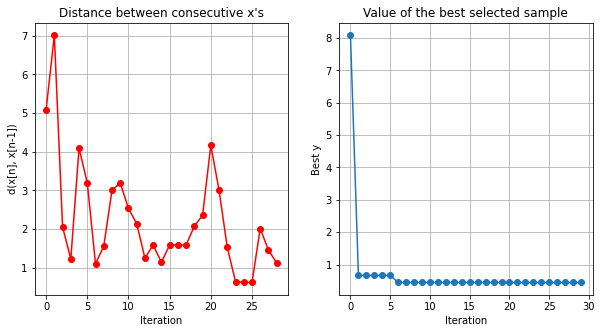

k-fold:  20%|██        | 1/5 [00:58<03:53, 58.45s/it]

0.07871982773276492 0.3576468151624706
0.9533517916400823 0.7910280899754668
0.8664888148197302 0.39798004550590443
0.6824026488528234 0.8714403138246444
0.05769165165997991 0.9740128474828124
0.0001 0.0001
1.1 1.1
1.1 0.0001
0.5368173425232138 1.1
0.5381907278943625 0.0001
0.10920451746920544 0.4930393169083507
1.0734249899884827 0.7118039921176772
0.5405299823550652 0.7748103923455938
1.0927978377651126 0.0500409114573334
0.030829192042325974 0.0056049404596833115
0.3571776058901205 0.3277728375028149
0.8701721192103713 0.9736028498659635
0.016958590958413858 0.11570051869902451
0.0036508827827925376 0.2705444822263121
0.025206627331383968 1.0790181819102111
1.03751046318505 0.24651436683760347
0.003191688570212298 0.6758223898010229
0.25989384072041877 1.0932818771382722
0.8318424028935207 0.024344991273293586
0.6156361568054964 0.9116128894457375
0.5418498498803818 0.9527235706462281
0.1852828807429877 0.008606930408775316
0.8332236616239205 0.7613577654582311
0.3193749171758477 0.

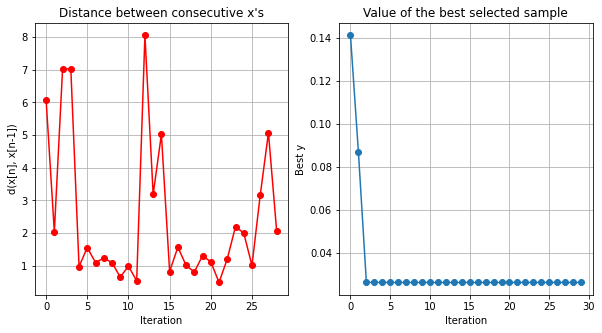

k-fold:  40%|████      | 2/5 [01:30<02:08, 42.75s/it]

0.5100933397045636 0.030848867242752237
0.07197488318156411 0.39647100855982215
0.24493272153802312 0.08982236433687021
0.4451616912576575 0.8070111660317306
0.060588928086123595 0.43863030777551415
1.1 0.0001
0.0001 0.0001
1.1 1.1
0.00010000000000000286 1.1
0.5475324407315443 0.5723016201434973
0.5444301309577116 1.1
0.5513113396706332 0.0001
1.1 0.0001
1.098415125929701 0.6532913917739569
0.06213213805265182 0.6927561774280081
1.0985539997537084 0.9707018715602179
0.18061740998044884 0.26921235718395214
0.8163897452459833 0.2616438448073553
0.8569959311360403 0.9653072830946281
0.1679213936710722 1.0179230243070156
0.2890313646336077 0.9076056275583511
0.08314892579791995 0.023795138518455525
1.0917851700829755 1.0097555814976664
1.075691120742637 0.27670369686027574
0.21292869561283462 0.024791589181885898
1.0078405788355516 0.0064486049271042815
0.0024358517836220043 0.22259943732350973
1.053226446812077 0.14363445956661372
0.8201975379170381 0.0023121315131227043
0.098473629227645

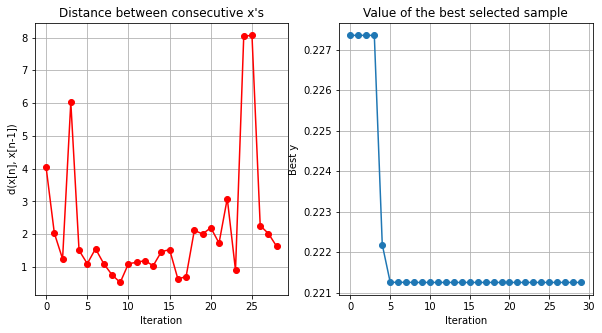

k-fold:  60%|██████    | 3/5 [02:05<01:18, 39.26s/it]

0.3761748151572443 0.6749093848293405
0.8056047919170106 0.689366539863539
0.5078504510079239 0.8349798693548645
0.753601203367427 0.5059423275024872
0.6716212299203059 0.08172558411206846
0.9706719333547369 0.7902783509413676
0.6682184163167862 0.015045353391764915
0.0001 0.0001
1.1 0.0001
0.0001 0.0001
0.469993316106552 0.49801345918832457
0.0001 1.1
0.7723170431929396 1.1
0.43687835906087713 1.1
0.0001 1.1
0.0001 0.6190797528813836
1.1 1.1
0.31430321466705163 0.0001
1.1 0.0001
1.1 1.1
0.0001 1.1
1.1 1.1
1.1 1.1


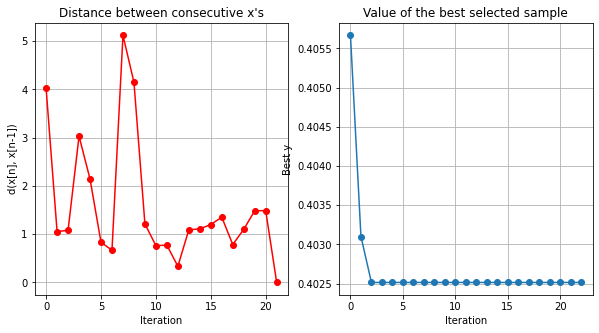

k-fold:  80%|████████  | 4/5 [03:15<00:51, 51.47s/it]

0.5467802775071903 0.330571571695602
1.0512858770574731 0.638558030716316
0.33522815592725824 0.806218051753097
0.25997578828605183 0.42799014194519996
1.0006784799588757 0.8112972497154822
0.0001 0.0001
0.0001 0.0001
0.0001 1.1
0.0001 1.1
1.1 0.00010000000000000286
1.1 0.0001
1.1 1.1
0.5509102633858212 0.5207403623943941
1.1 0.0001
0.0001 1.1
1.1 1.1
0.0001 0.0001
0.0001 0.5544451937919287
1.1 0.5491405084201556
0.5463612338585931 0.5492201421763114
0.5551565167618469 0.0001


k-fold:  80%|████████  | 4/5 [04:03<01:00, 60.81s/it]


KeyboardInterrupt: 

In [23]:
if treinar['BayesianPolinomialLinearRegression']:
    resultado_parcial = validacao_cruzada(Modelo=BayesianPolinomialLinearRegression, dominio=dominio_regressao_linear_bayesiana_polinomial, X=X_train, y=y_train)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])

In [ ]:
if treinar['RBFLinearRegression']:
    resultado_parcial = validacao_cruzada(Modelo=RBFLinearRegression, dominio=dominio_regressao_linear_bayesiana_rbf, X=X_train, y=y_train)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])

#### Resultado prelimiar

In [ ]:
relatorio_modelos.sort_values(['rmse', 'nlpd']).groupby(['modelo', 'fold']).first()